# Motivation

This notebook is using the standard network generated from the non-cancerous dataset. It explores the subtypes derived of the non-tumour dataset using the standard network.

In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio

import multiprocess as mp

sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.utilities.helpers import save_fig

from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import gsea as gsea_hp

import graph_tool.all as gt

# %matplotlib inline

pio.templates.default = "ggplot2"


pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/network_II/"

figures_path = "../network_II/standard/"

sbm_exps_path = "sbm/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

all_tum_tpms = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

healthy_metadata = pd.read_csv(f"{data_base}/metadata/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample", dtype_backend="pyarrow")
genes_biotypes = pd.read_csv(f"{data_base}/gc44_genes_biotypes.tsv", sep="\t", index_col="genes")

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Load experiments

In [3]:
hsbm_v3 = ExperimentSet("v3", base_path=base_path, exp_path=sbm_exps_path, mut_df=tcga_mutations_df, sel_sets=None, exp_type="iNet")

exps = {}
for idx, exp in enumerate(hsbm_v3.get_exps()):
    if exp.sbm_method != "hsbm":  # or idx != 2:
        continue

    print(f"Loading Graph-Tool for {exp.type}")
    exps[exp.type] = GtExp.from_pgcna_inet(exp, rel_path="")
    exps[exp.type].export_to_gephi(save=False)

hsbm_v3.exps = exps

##### Experiment labels:  dict_keys(['standard_5K_6TF_sbm', 'standard_5K_6TF_hsbm', 'sigmoid_5K_6TF_hsbm'])
Loading Graph-Tool for standard_5K_6TF_hsbm
Loading Graph-Tool for sigmoid_5K_6TF_hsbm


In [4]:
%autoreload 2
sel_gt: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]
gt_state: gt.NestedBlockState = sel_gt.hstateObj["state"]

sel_gt.hsbm_add_vp(mut_df=tcga_mutations_df)

gt_g = sel_gt.gt_g
pv = sel_gt.hstateObj["pv"]
pmode = sel_gt.hstateObj["pmode"]

com_df, _ = sel_gt.hsbm_get_gt_df()
com_df["max_b"] = com_df["P_lvl_0"]

gt.remove_self_loops(gt_g)

######## ModCon and MEVS ########
sel_gt.gt_modCon_MEV(all_tpms=sel_gt.tpm_df)

# Compute and store the nodes/edges with all the information
sel_gt.export_to_gephi(save=False, com_df = com_df)
sel_gt.add_gt_prop_draw(gt_g, com_df=com_df, tf_list=tf_list)
graph_stats = sel_gt.compute_graph_stats()

nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=sel_gt.nodes_df, tpm_df=sel_gt.tpm_df)

In [5]:
if 0:
    nodes_df[["max_b", "ModCon_Rank", "mean", "median", "std", "var", "count", "ctrl_tf"]].to_csv(figures_path + "nodes_df_hsbm.tsv", sep="\t")
    # sel_gt.export_to_gephi(save=True, com_df=com_df[["max_b", "node_idx"]])

# Non-tum Analysis

## Export to Morpheus

In [6]:
label = "hsbm_std"
sel_gt.gt_modCon_MEV(all_tpms=sel_gt.tpm_df)
cs_exp, fig_std, metrics = gh.run_clusters(sel_gt, label="hsbm_std", show_figs=False)

# Combine clustering with the Mevs
cluster_cols = [f"RawKMeans_CS_{7}_hsbm_std"]
mevs_cs = pd.concat([cs_exp[cluster_cols], sel_gt.mevsMut], axis=1)

healthy_cols = healthy_metadata.columns
mevs_cols = sel_gt.mevsMut.columns

# Add the metadata
comb_df = pd.concat([healthy_metadata.drop("Y2796_P0"), mevs_cs], axis=1).dropna(how="all")

# reorder columns
comb_df[list(healthy_cols) + list(cluster_cols) + list(mevs_cols)].T

# save the file
label = f"{sel_gt.type}"
filename = f"healthy_{label}_v3_1"
path = f"{figures_path}/Morpheus/non_tum/{filename}.tsv"

comb_df.transpose().to_csv(path, sep="\t", index=True)

Variation per principal component [0.47958678 0.32651145] and the sum 80.61%


## Import morpheus

In [7]:
filename = f"healthy_{label}_v3_1"

morpheus_path = f"{figures_path}/Morpheus/non_tum/norm_{filename}.gct"

morp_df = pd.read_csv(morpheus_path, sep="\t", skiprows=2)

columns = morp_df["id"]
morp_df = morp_df.transpose()
morp_df.columns = columns
morp_df = morp_df.iloc[2:, :]

morp_df.rename_axis("sample", axis="columns", inplace=True)
# Group 4 has just one sample
morp_df.loc[morp_df["dendrogram_cut"] == "1.00", "dendrogram_cut"] = "2.00"

In [8]:
# morp_df["subset_name"].replace("Uro", "Bl", inplace=True)
#

morp_df.loc[morp_df["subset_name"].isnull(), "subset_name"] = "Uro-DMSO"
reorder_cols = [
    "NHU_differentiation",
    "dendrogram_cut",
    "subset_name",
    # "RawKMeans_CS_7_rwd_mut",
    "Biological sex",
]
remap_cols = {"NHU_differentiation": "NHU Differentiation", "dendrogram_cut": "Dendrogram cut", "subset_name": "Subset name", "Gender": "Biological sex"}
morp_df.rename(columns=remap_cols, inplace=True)

meta, sky_fig = sky.main(df=morp_df.fillna("NA"), reorder_cols=remap_cols.values(), title="Non-tum", retMeta=True)
sky_fig = sky_fig.update_layout(
    title="",
    font=dict(size=20),
    # paper_bgcolor="rgba(0,0,0,0)",
)
sky_fig = sky_fig.update_annotations(font_size=22)
save_fig(name="non_tum_split", fig=sky_fig, base_path=f"{figures_path}", width=1600, height=700)

### Export for DEA

In [9]:
morp_df.to_csv(f"{figures_path}/Morpheus/non_tum/prcsd_morpheus_cs_7.tsv", sep="\t", index_label="sample")

# Export to show the communities on the Volcano plot
_ = gh.export_top_modCon_genes(nodes_df=sel_gt.nodes_df, path=figures_path, top_n=100, metric="median")
modConRank_genes = gh.export_top_modCon_genes(nodes_df=sel_gt.nodes_df, path=figures_path, top_n=100, metric="ModCon_Rank")

### Export for cluster tree

In [10]:
cluster_labels = sel_gt.nodes_df[["P_lvl_0", "P_lvl_1", "P_lvl_2", "P_lvl_3", "P_lvl_4"]].copy(deep=True)
cluster_labels.to_csv(f"{figures_path}/cluster_tree/cluster_tree_std_v3.csv")

# reverse the columns
cluster_labels.columns = cluster_labels.columns[::-1]
cluster_labels.to_csv(f"{figures_path}/cluster_tree/cluster_tree_std_v3_reverse.csv")

## DEA

### P0 Split

In [11]:
dea_path = "../../data/non_cancerous/dea/norm_splits/"

f_male_diff_small = "sleuth_5.0_6.0_v3_vulcano_labels.tsv"
f_male_diff_large = "sleuth_5.0_7.0_v3_vulcano_labels.tsv"
f_small_large_diff = "sleuth_6.0_7.0_v3_vulcano_labels.tsv"
f_p0_comp = "sleuth_P0_small_P0_large_vulcano_labels.tsv"

markers = modConRank_genes.to_dict("list")

In [12]:
sel_coms = [19, 22, 25, 29]
filter_dict = {f"{key}_ModCon": markers[key] for key in sel_coms}

dmy = {
    "text": [
        "COX7B",
        "ENSG00000232035",
        "RPL36A-HNRNPH2",
        "ENSG00000249731",
        "ENSG00000266340",
        "GASK1A",
        "IGFL4",
        "MAB21L3",
        "SNHG25",
        "ENSG00000262580",
        "SGSH",
        "ENSG00000266340",
        "COX7B",
        "ARIH1",
        "MKKS",
        "SULRT1A3",
        "ENSG00000260772",
        "LINC01001",
        "AKTIP",
        # Righ hand side
        "ENSG00000285043",
        "BCL10-AS1",
        "ENSG00000278456",
        "ENSG00000288934",
        "ENSG00000289293",
        "ENSG00000288545",
        "PICART1",
        "DNAJB14",
        "ADM",
        "IL1RL2",
        "IVL",
        "COQ8B",
        "ALDH1A3",
        "MAP4K4",
    ]
}
filter_dict.update(dmy)

volcano = dea.volcano(f_p0_comp, base_path=dea_path, known_markers=False, markers=filter_dict)


# volcano = dea_hp.toggle_legend(volcano, kept_traces=["0", "Point(s) of interest", "Dataset"])
volcano.add_annotation(text="P0 large", x=-4, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))
volcano.add_annotation(text="P0 small", x=2, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))

volcano = volcano.update_layout(
    title="",
    legend=dict(
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.98,
        x=0.6,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=17, color="#003366"),
    ),
    xaxis_tickfont_size=20,
    yaxis_tickfont_size=20,
    xaxis_title_font_size=25,
    yaxis_title_font_size=25,
    font=dict(size=16),
    height=1000,
    # height=900,
)
# volcano.update_traces(marker=dict(size=14, opacity=0.6), selector=dict(mode="markers"))
volcano.show()

Finished loading the data in 0.05732393264770508


### Diff split

In [13]:
sel_coms = [19, 1, 29, 25, 22]
filter_dict = {f"{key}_ModCon": markers[key] for key in sel_coms}

dmy = {
    "text": [
        "ENSG00000288934",
        "PPP1R12A-AS2",
        "RBM14-RBM4",
        "SPAAR",
        "C7orf25",
        "COQ8B",
        "ENSG00000273308",
        "ENSG00000255439",
        "ENSG00000223837",
        "ENSG00000263325",
        "ENSG00000237870",
        # For right side
        "ENSG00000266340",
        "ENSG00000286147",
        "ENSG00000286834",
        "COX7B",
        "DNM1",
        "ENSG00000232035",
        "RPL36A-HNRNPH2",
        "TALAM1",
        "ENSG00000249731",
        "SNRPD1",
        "IGFL4",
        "MAB21L3",
        "LINC01001",
    ]
}
filter_dict.update(dmy)


volcano = dea.volcano(f_small_large_diff, base_path=dea_path, known_markers=False, markers=filter_dict)

# volcano = dea_hp.toggle_legend(volcano, kept_traces=["0", "Point(s) of interest", "Dataset"])
volcano.add_annotation(text="Abs-Ca large", x=-3, y=19, showarrow=False, font=dict(size=20, color="#177c7a"))
volcano.add_annotation(text="Abs-Ca small", x=5, y=19, showarrow=False, font=dict(size=20, color="#177c7a"))

volcano = volcano.update_layout(
    title="",
    legend=dict(
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.98,
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=17, color="#003366"),
    ),
    xaxis_tickfont_size=20,
    yaxis_tickfont_size=20,
    xaxis_title_font_size=25,
    yaxis_title_font_size=25,
    font=dict(size=16),
    height=1100,
)
volcano.show()

Finished loading the data in 0.04490399360656738


## Male specific

In [14]:
config = {"file_1": f_male_diff_large, "file_2": f_male_diff_small, "ref_x": "max", "ref_y": "min"}
pi, pi_df = gsea_hp.rank_pi_vals("maleSpecific", config, dea_path=dea_path, custom_points={}, show_known_markers=False)
# pi.show()

## GSEA

In [15]:
import gseapy as gp

msigdb_hallmarks = "../../data/GSEA/msigDB/h.all.v2023.2.Hs.symbols.gmt"
msigdb_reactome = "../../data/GSEA/msigDB/c2.cp.reactome.v2023.2.Hs.symbols.gmt"
msigdb_tf = "../../data/GSEA/msigDB/c3.tft.v2023.2.Hs.symbols.gmt"
msigdb_cancer = "../../data/GSEA/msigDB/c4.all.v2023.2.Hs.symbols.gmt"
msigdb_onco_sig = "../../data/GSEA/msigDB/c6.all.v2023.2.Hs.symbols.gmt"
msigdb_all = "../../data/GSEA/msigDB/msigdb.v2023.2.Hs.symbols.gmt"

databases = {
    "hallmark": {"path": msigdb_hallmarks},
    # "onco_sig": {"path": msigdb_onco_sig},
    "reactome": {"path": msigdb_reactome},
    ### Un-comment to run the following pathways
    # "tf": { "path": msigdb_tf },
    # "can_path": { "path": msigdb_cancer }, #canonical pathway
    # "all": { "db": msigdb_all },
}

runs_config = {"male_specific": {"file_1": f_male_diff_large, "file_2": f_male_diff_small, "ref_x": "max", "ref_y": "min"}}

In [16]:
if 0:
    new_runs = {}
    version = "v1"
    for subtype, config in runs_config.items():
        print(f"##### {subtype} #####")

        path = f"{figures_path}/GSEA/{version}/{subtype}"

        # Add the path
        config["path"] = path

        # Run the Pi value - the saved Pi plot is a check for selecting the right quadrant
        config["pi"], config["pi_df"] = gsea_hp.rank_pi_vals(subtype, config, dea_path=dea_path, custom_points={})

        # Run the GSEA
        gsea_res = gsea_hp.run_gsea(subtype, config, databases=databases)

        # Merging two dict, requires python >3.5
        new_runs[subtype] = {**config, **gsea_res}

In [17]:
if 0:
    for subtype, config in new_runs.items():

        for key, value in databases.items():
            print(f"{subtype} --> {key}")
            rank_gsea = config[key]
            base_path = config["path"]
            _, _ = gsea_hp.plot_top_gsea(res=rank_gsea, path=base_path, num=10, label=f"{subtype}_{key}", database=key)

## GSEA using the DEA plots

In [18]:
dea_absCa = pd.read_csv(f"{dea_path}/{f_small_large_diff}", sep="\t", index_col="genes")
dea_p0 = pd.read_csv(f"{dea_path}/{f_p0_comp}", sep="\t", index_col="genes")

dea_abs_large, dea_abs_small = dea_absCa.copy(deep=True), dea_absCa.copy(deep=True)
dea_p0_large, dea_p0_small = dea_p0.copy(deep=True), dea_p0.copy(deep=True)

# # Abs large
dea_abs_large["rank"] = dea_absCa["pi"].rank(ascending=True, method="first")
dea_abs_small["rank"] = dea_absCa["pi"].rank(ascending=False, method="first")
# P0
dea_p0_large["rank"] = dea_p0["pi"].rank(ascending=True, method="first")
dea_p0_small["rank"] = dea_p0["pi"].rank(ascending=False, method="first")

configs = {
    "abs_large": dea_abs_large,
    "abs_small": dea_abs_small,
    "p0_large": dea_p0_small,
    "p0_small": dea_p0_large,
}

version = "v2"
path = f"{figures_path}/GSEA/volcano/{version}"

In [19]:
results = {}
subtype = "dea_volcano"
for exp, dmy_df in configs.items():
    df = dmy_df.reset_index(names="genes")[["genes", "rank"]]
    base_path = f"{figures_path}/GSEA/volcano/{version}/{exp}/"
    for key, value in databases.items():
        # database
        print(f"--> {key}")
        gsea_path = f"{base_path}/{key}/"
        rank_gsea = gp.prerank(
            rnk=df,
            gene_sets=value["path"],
            permutation_num=1000,
            outdir=gsea_path,
            format="png",
            no_plot=False,
            ascending=False,
            seed=20,
            graph_num=10,
            threads=12,
        )  # Change graph_num if you want to produce enrichment plots

        value["res"] = rank_gsea

        # Plot summaries plot
        try:
            _ = gsea_hp.plot_enrichr_summary(rank_gsea.res2d, label=key, savePath=gsea_path)
            _, _ = gsea_hp.plot_top_gsea(res=rank_gsea, path=base_path, num=10, label=f"{exp}_{key}", database=key)
        except:
            print(f"No enrichment >0.05 for {exp} - {key}")

        results[key] = rank_gsea

--> hallmark
No enrichment >0.05 for abs_large - hallmark
--> reactome
No enrichment >0.05 for abs_large - reactome
--> hallmark
--> reactome
--> hallmark
No enrichment >0.05 for p0_large - hallmark
--> reactome
No enrichment >0.05 for p0_large - reactome
--> hallmark
--> reactome


# Exploring the Ensembl genes

In [20]:
sel_coms = [19, 1, 29, 25, 2]
genes = nodes_df.loc[nodes_df["max_b"].isin(sel_coms)]["Gene"].to_list()

In [21]:
dmy_df = genes_biotypes.loc[genes_biotypes.index.isin(genes)]
# dmy_df = dmy_df.loc[dmy_df["gene_type"] != "protein_coding"]

# for biotype_genes, row in dmy_df.iterrows():
sel_df = pd.DataFrame()
for gene in genes:
    found = genes_biotypes.loc[genes_biotypes.index.str.contains(gene)]
    if found.shape[0]:
        sel_df = pd.concat([sel_df, found], axis=0)

In [22]:
sel_df["gene_type"].value_counts()

gene_type
protein_coding                        423
lncRNA                                193
transcribed_unprocessed_pseudogene      3
Name: count, dtype: int64

# MIBC Analysis

## Export to Morpheus

In [23]:
######## Tissue type based on Community from healthy ########
comm_meta = {
    "diff": [8, 20, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33],
    "p0": [0, 1, 2, 3, 4, 5, 6, 7, 16, 17],
    "undiff": [9, 10, 11, 12, 13, 14, 15, 21, 34],
    "p0_ud": [18],
    "misfit": [19, 29],
}

comm_meta_df = []
for key, comunities in comm_meta.items():
    for com in comunities:
        comm_meta_df.append((key, f"Com_{com}", com))
diff_type = pd.DataFrame(comm_meta_df, columns=["Diff Type", "Com", "Com_idx"]).sort_values(by=["Com_idx"]).set_index("Com")

In [24]:
# # from observations
# Samples which were clustered in their single group
samples_to_remove = ["TCGA-5N-A9KI", "TCGA-DK-A2HX", "TCGA-XF-A8HD", "TCGA-G2-A2EF"]

# Add the samples thare grouped in 2 (cut - 11)
samples_to_remove.extend(["TCGA-XF-AAN0", "TCGA-4Z-AA7Q"])

# Add another sample which was an outlier in 3.2
samples_to_remove.extend(["TCGA-FD-A3SR", "TCGA-CF-A9FH"])

# pre-processing
f_tum = all_tum_tpms.drop(columns=samples_to_remove)

In [25]:
sel_gt.gt_modCon_MEV(all_tpms=f_tum, is_imev=True, com_df=com_df)
cs_exp, cs_figs, metrics_figs = gh.run_clusters(sel_gt, label="iMEV", show_figs=True, norm=False)

settings = {
    "cs_num_1": 5,
    "cs_num_2": 7,
    "sel_mut": pd.DataFrame(),
    "vu_output": vu_output,
    "cs_exp": cs_exp,
    "figures_path": f"{figures_path}/Morpheus/tum/",
    "label_col_cs": "iMEV",
    "filename": f"tum_{sel_gt.type}_iMev_3.3",
    "diff_type": diff_type,
    # 3.0 - with all the samples
    # 3.1 - without the samples that are in a single group
    # 3.2 - without the samples that are in pair
    # 3.3 - extra sample as an outliar
}

tum_morph = sel_gt.export_morpheus(settings)

Variation per principal component [0.51363944 0.29612881] and the sum 80.98%


In [26]:
K = 7
label = f"RawKMeans_CS_{K}_iMEV"
reorder_cols = [
    "2019_consensus_classifier",
    # "KMeans_labels_6",
    "TCGA408_classifier",
    # label,
]

meta, sky_fig = sky.main(
    df=vu_output.dropna(), reorder_cols=reorder_cols, title="{}. Comp between {} ".format("SBM derived ", ", ".join(reorder_cols)), retMeta=True
)
sky_fig.show()

In [27]:
if 1:
    morpheus_path = f"{figures_path}/Morpheus/tum/"

    morp_df = pd.read_csv(f"{morpheus_path}/norm_tum_standard_5K_6TF_hsbm_iMev_3.3.gct", sep="\t", skiprows=2)

    columns = morp_df["id"]
    morp_df = morp_df.transpose()
    morp_df.columns = columns
    morp_df = morp_df.iloc[2:, :]

    morp_df.rename_axis("sample", axis="columns", inplace=True)
    reorder_cols = [
        "TCGA",
        # "KMeans_labels_6",
        "dendrogram_cut",
        # "RawKMeans_CS_7_rwd_mut",
        "Consensus",
    ]
    meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols, title="{}. Comp between {} ".format("SBM derived ", ", ".join(reorder_cols)), retMeta=True)
    sky_fig.show()

## Visualising SBM

In [28]:
sel_gt: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]
gt_g: gt.Graph = sel_gt.gt_g

com_df, _ = sel_gt.hsbm_get_gt_df()
sel_gt.graph_type = "sbm"
sel_gt.nodes_df["node_idx"] = com_df["node_idx"]
sel_gt.nodes_df["max_b"] = com_df["max_b"]

sel_gt.hsbm_add_vp(mut_df=tcga_mutations_df)
sel_gt.add_gt_prop_draw(sel_gt.gt_g, com_df=com_df, tf_list=tf_list)

gt_state: gt.NestedBlockState = sel_gt.hstateObj["state"]
pv = sel_gt.hstateObj["pv"]

vp_dg = gt_g.degree_property_map(deg="total", weight=gt_g.ep["weight"])

In [29]:
sel_gt.gt_g.set_vertex_filter(None)
sel_gt.show_comms(communities=[7])
# sel_gt.gt_g.set_vertex_filter(None)

/Users/vlad/opt/anaconda3/envs/iNet_gt/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:668: UserWarning:

Unknown parameter: display_props



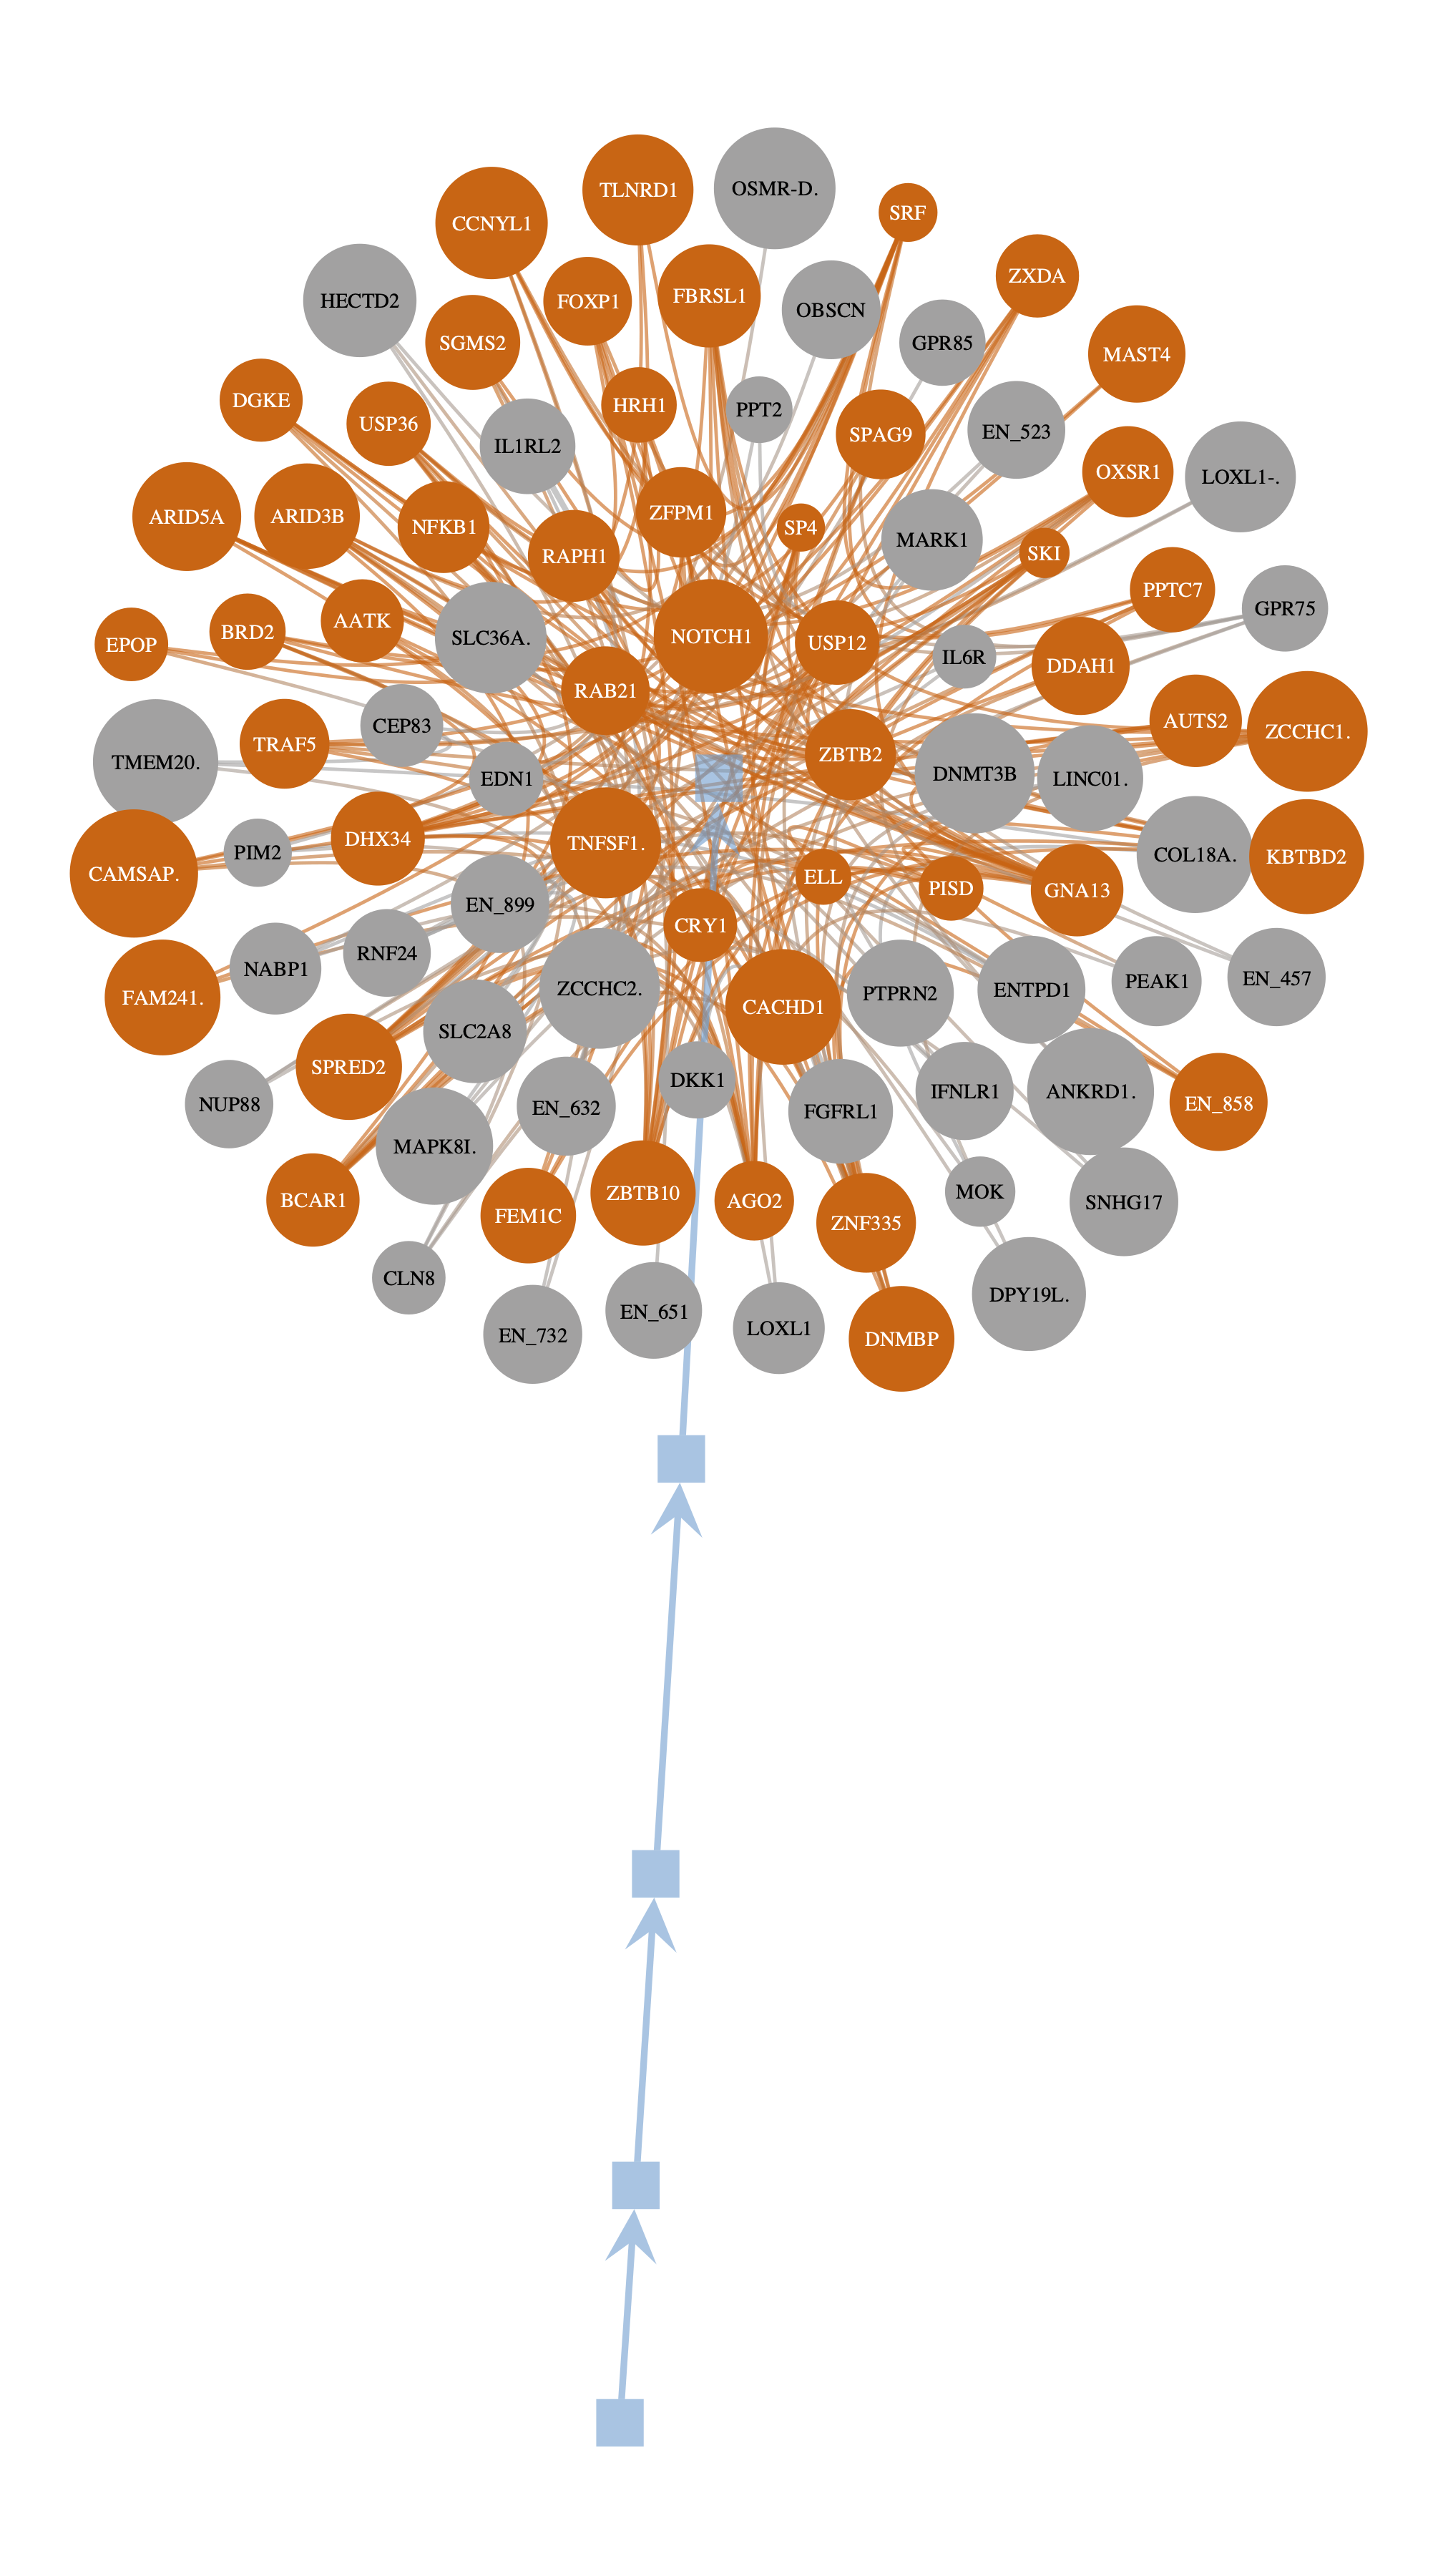

In [30]:
draw_results = gt_state.draw(
    # pos=pos,
    layout="sfdp",
    # vertex_shape="pie",
    # vertex_pie_fractions=pv,
    inline=True,
    vertex_color=gt_g.vp["colors_rank"],
    # vertex_color=gt.prop_to_size(gt_g.vp["modCon_rank"], 0, 100, power=0.1),
    vertex_text=gt_g.vp.prcsd_gene,
    display_props=gt_g.vp.display_prop,
    # subsample_edgesint=int(gt_g.num_edges() * 0.5),
    output_size=(1800, 1800),  # good to visualised in Notebook
    # ######## For mut_count ########
    # vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 5, 10, power=0.5),
    # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 2, 10, power=1),
    # vertex_size=gt.prop_to_size(vp_dg, 35, 35, power=1),
    ######## is TF ########
    # vertex_size=gt.prop_to_size(gt_g.vp.is_tf, 10, 30, power=0.5),
    # vertex_font_size=gt.prop_to_size(gt_g.vp.mut_count, 5, 20, power=1),
    ##### edges properties
    # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 5, 10, power=0.01, log=True),
    # output=f"{figures_path}/sel_communities.pdf",
    # hide=0,
    nodesfirst=False,
    # beta=0.7,
    # chord_scale=5,
    # display_props_size=16,
)

In [31]:
com_7 = sel_gt.nodes_df[sel_gt.nodes_df["max_b"] == 7][["Gene", "count", "TF", "max_b", "ModCon_Rank", "mean", "median", "std", "var"]]

px.scatter(com_7, x="Gene", y="median", size="count")

# Network Analysis

## Level membership

In [32]:
if 1:
    fig = sel_gt.hsbm_plot_posterior()
    fig.show()

Lvl 0, non-empty 34; B 5001; N: 92
Lvl 1, non-empty 14; B 14; N: 34
Lvl 2, non-empty 7; B 7; N: 14
Lvl 3, non-empty 3; B 3; N: 7
Lvl 4, non-empty 1; B 2; N: 3
